In [1]:
import os

adr_nbbo_dir = os.path.join('../data/raw/adrs/bbo-1m/nbbo')
etf_nbbo_dir = os.path.join('../data/raw/etfs/market/bbo-1m/nbbo')
adr_info_filename = os.path.join('..', 'data', 'raw', 'adr_info.csv')
futures_symbols_filename = os.path.join('../data/raw/futures_symbols.csv')
signal_dir = os.path.join('..', 'data', 'processed', 'futures_only_signal')
close_filename = os.path.join('..', 'data', 'raw', 'adrs', 'adr_PX_LAST_adjust_none.csv')
hedge_ratio_filename = os.path.join('..', 'data', 'processed', 'market_etf_hedge_ratios.csv')
etf_filename = os.path.join('..', 'data', 'raw', 'etfs', 'market', 'market_etf_PX_LAST_adjust_none.csv')
domestic_close_mid_filename = os.path.join('..', 'data', 'processed', 'adrs', 'adr_mid_at_ord_auction_adjust_none.csv')

In [2]:
import pandas as pd

close_df = pd.read_csv(close_filename, index_col=0, parse_dates=True)
#dom_close_df = pd.read_csv(domestic_close_mid_filename, index_col=0, parse_dates=True)
ratio_df = pd.read_csv(hedge_ratio_filename, index_col=0, parse_dates=True)
etf_close_df = pd.read_csv(etf_filename, index_col=0, parse_dates=True)
adr_info = pd.read_csv(adr_info_filename)
adr_info['adr_tickers'] = adr_info['adr'].str.replace(' US Equity','')
hedge_dict = adr_info.set_index('adr_tickers')['market_etf_hedge'].to_dict()

In [3]:
adr_bars = pd.read_parquet('../data/raw/adrs/minute_bars_UNADJUSTED/',columns=['Volume','ticker'])

In [4]:
adr_bars = adr_bars.between_time('09:30', '16:00').pivot(columns='ticker',values='Volume')

In [5]:
adr_bars = adr_bars.fillna(0)

In [6]:
import sys
sys.path.append('../src')
import utils

cbday = utils.get_market_business_days('XNYS')
pre_close = adr_bars.between_time('15:50', '16:00')
afternoon_volume = adr_bars.between_time('12:30', '16:00').groupby(pd.Grouper(freq=cbday)).sum()
total_volume = adr_bars.groupby(pd.Grouper(freq=cbday)).sum()
volume_pre_close = pre_close.groupby(pd.Grouper(freq=cbday)).sum()
adr_frac = (volume_pre_close/afternoon_volume)
del adr_bars

In [ ]:
params = utils.load_params()
start_date = params['start_date']
end_date = params['end_date']
futures_dir = '../data/processed/futures/converted_minute_bars'
futures_bars = pd.read_parquet(futures_dir,
                                filters=[('timestamp','>=', pd.Timestamp(start_date, tz='America/New_York')),
                                        ('symbol','in', ('FTUK','FESX','NIY'))],
                                columns=['timestamp','symbol','volume'])

futures_bars = futures_bars.set_index('timestamp')

In [86]:
pre_close = futures_bars.between_time('15:50', '16:00')
afternoon_volume = futures_bars.between_time('12:30', '16:00').groupby([pd.Grouper(freq=cbday),'symbol'], observed=True).sum()
total_volume = futures_bars.groupby([pd.Grouper(freq=cbday),'symbol'], observed=True).sum()
volume_pre_close = pre_close.groupby([pd.Grouper(freq=cbday),'symbol'], observed=True).sum()
fut_frac = (volume_pre_close/afternoon_volume)

In [87]:
fut_frac = fut_frac['volume'].unstack()
fut_frac.index = fut_frac.index.tz_localize(None).normalize()

In [88]:
from scipy.stats import percentileofscore

adr_scores = adr_frac.rolling(250, min_periods=1).apply(lambda x: percentileofscore(x.dropna(), x[-1]))
fut_scores = fut_frac.rolling(250, min_periods=1).apply(lambda x: percentileofscore(x.dropna(), x[-1]))

/tmp/ipykernel_14229/83498699.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adr_scores = adr_frac.rolling(250, min_periods=1).apply(lambda x: percentileofscore(x.dropna(), x[-1]))
/tmp/ipykernel_14229/83498699.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fut_scores = fut_frac.rolling(250, min_periods=1).apply(lambda x: percentileofscore(x.dropna(), x[-1]))


In [91]:
symbol_dict = pd.read_csv('../data/raw/futures_symbols.csv').set_index('bloomberg_symbol')['first_rate_symbol'].to_dict()
adr_info['first_rate_symbol'] = adr_info['index_future_bbg'].map(symbol_dict)
adr_info['adr_ticker'] = adr_info['adr'].str.replace(' US Equity','')
futures_dict = adr_info.set_index('adr_ticker')['first_rate_symbol'].to_dict()

In [92]:
import numpy as np

def f(adr,fut):
    x = np.log(adr) - np.log(fut)
    return 1 / (1 + np.exp(2*x))

In [93]:
stacked_adr = adr_scores.stack().rename('adr_score').reset_index()
stacked_adr['future_symbol'] = stacked_adr['ticker'].map(futures_dict)
stacked_fut = fut_scores.stack().rename('fut_score').reset_index()
score_merged = pd.merge(stacked_adr, stacked_fut, left_on=['DateTime','future_symbol'], right_on=['timestamp','symbol'])


In [94]:
score_merged['volume_factor'] = score_merged[['adr_score','fut_score']].apply(lambda x: f(x['adr_score'], x['fut_score']), axis=1)
volume_factors = score_merged.pivot(index='DateTime', columns='ticker', values='volume_factor')

In [96]:
asia_tickers = adr_info[adr_info['country'].isin(['JAPAN','AUSTRALIA'])]['adr_ticker'].tolist()    

In [ ]:
import numpy as np

measured_time = [
                '13:00:00',
                '13:30:00',
                '14:00:00',
                '14:30:00',
                '15:00:00',
                '15:30:00',
                '15:35:00',
                '15:40:00',
                '15:45:00',
            ]

volume_lookback = 250
min_p = 0.2
t0_for_cov  = '14:00:00'
all_daily = []
all_ic = {}
all_hedged_ic = {}
all_volume_scaled_ic = {}
pre_25_ic = {}
post_25_ic = {}
scaled_post_25_ic = {}
low_flow_ic = {}
frac_volume = (volume_pre_close/afternoon_volume)
for ticker in close_df.columns:
    hedge_ticker = hedge_dict[ticker]
    all_ic[ticker] = []
    all_hedged_ic[ticker] = []
    all_volume_scaled_ic[ticker] = []
    pre_25_ic[ticker] = []
    post_25_ic[ticker] = []
    scaled_post_25_ic[ticker] = []
    low_flow_ic[ticker] = []
    df = pd.read_parquet(os.path.join(adr_nbbo_dir, f'ticker={ticker}'), columns=['nbbo_bid', 'nbbo_ask'])
    df['mid'] = (df['nbbo_bid'] + df['nbbo_ask']) / 2
    df['date'] = df.index.tz_localize(None).normalize()
    merged = df.merge(close_df[[ticker]].dropna().rename(columns={ticker: 'close'}), left_on='date', right_index=True)
    
    etf_df = pd.read_parquet(os.path.join(etf_nbbo_dir, f'ticker={hedge_ticker}'), columns=['nbbo_bid', 'nbbo_ask'])
    etf_df['etf_mid'] = (etf_df['nbbo_bid'] + etf_df['nbbo_ask']) / 2
    merged = etf_df[['etf_mid']].merge(merged, left_index=True, right_index=True)
    merged = merged.merge(etf_close_df[[hedge_ticker]].dropna().rename(columns={hedge_ticker: 'etf_close'}), left_on='date', right_index=True,how='left')
    merged = merged.merge(ratio_df[[ticker]].dropna().rename(columns={ticker: 'hedge_ratio'}), left_on='date', right_index=True,how='left')

    signal_df = pd.read_parquet(os.path.join(signal_dir, f'ticker={ticker}'), columns=['signal'])
    merged = signal_df.merge(merged, left_index=True, right_index=True)
    
    for t0 in measured_time:
        daily = merged.between_time(t0, t0).copy()
        daily['adr_ret'] = (daily['close'] - daily['mid']) / daily['mid']
        daily['etf_ret'] = (daily['etf_close'] - daily['etf_mid']) / daily['etf_mid']
        daily['hedged_ret'] = daily['adr_ret'] - daily['hedge_ratio'] * daily['etf_ret']
        daily['signal'] = daily['signal']#.clip(-0.01, 0.01)

        # daily_volume = volume_df[[ticker]].rename(columns={ticker: 'volume'}).between_time(t0,t0).copy()
        # daily_volume['mean_volume'] = daily_volume['volume'].rolling(volume_lookback).mean()
        #daily_volume['volume_factor'] = daily_volume['volume'].rolling(volume_lookback).apply(get_volume_factor, args=(min_p,))
        # daily = daily.merge(daily_volume,
        #                     left_index=True, right_index=True,
        #                     how='left')
        # daily = daily.merge(frac_volume[[ticker]].rename(columns={ticker: 'frac_volume'}), 
        #                     left_on='date', right_index=True, how='left')
        daily = daily.merge(volume_factors[[ticker]].rename(columns={ticker: 'volume_factor'}), 
                            left_on='date', right_index=True, how='left')

        all_ic[ticker].append(daily['adr_ret'].corr(daily['signal']))
        all_hedged_ic[ticker].append(daily['hedged_ret'].corr(daily['signal']))
        all_volume_scaled_ic[ticker].append(daily['hedged_ret'].corr(daily['signal'] * daily['volume_factor']))
        #scaled_post_25_ic[ticker].append(daily.loc['2025-05':,'hedged_ret'].corr(daily.loc['2025-05':,'signal'] * daily.loc['2025':,'volume_factor']))

        # pre_25_ic[ticker].append(daily.loc[:'2024','hedged_ret'].corr(daily.loc[:'2024','signal']))
        # post_25_ic[ticker].append(daily.loc['2025':,'hedged_ret'].corr(daily.loc['2025':,'signal']))
        # low_flow_ic[ticker].append(daily.loc['2025':].loc[daily.loc['2025':]['frac_volume'] < 0.25,'hedged_ret'].corr(daily.loc['2025':].loc[daily.loc['2025':]['frac_volume'] < 0.25,'signal']))
        if t0 == t0_for_cov:
            daily['ticker'] = ticker
            daily['date'] = daily.index.tz_localize(None).normalize()
            all_daily.append(daily[['ticker', 'date', 'hedged_ret','adr_ret','signal']])
        
    #print(f'Ticker: {ticker}, ICs: {np.mean(all_ic[ticker]):.3f} hedged ICs: {np.mean(all_hedged_ic[ticker]):.3f}, volume scaled ICs: {np.mean(all_volume_scaled_ic[ticker]):.3f}')
    print(f'Ticker: {ticker}, hedged ret: {np.mean(all_hedged_ic[ticker]):.3f}, volume-scaled: {np.mean(all_volume_scaled_ic[ticker]):.3f}')

daily_df = pd.concat(all_daily, ignore_index=True)
# Drop any duplicates based on date and ticker, keeping the first occurrence
daily_df = daily_df.drop_duplicates(subset=['date', 'ticker'], keep='first')
adr_ret_daily = daily_df.pivot(index='date', columns='ticker', values='adr_ret')
hedged_ret_daily = daily_df.pivot(index='date', columns='ticker', values='hedged_ret')
signal_daily = daily_df.pivot(index='date', columns='ticker', values='signal')

In [45]:
volume_factors['TAK']

KeyError: 'TAK'

<Axes: xlabel='DateTime'>

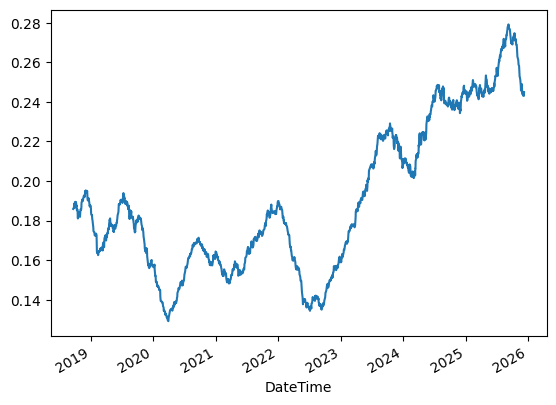

In [ ]:
frac_volume['NOK'].rolling(100).mean().plot()

In [ ]:
compare

,pre,post
SHEL,-0.041103,-0.220831
UL,0.062238,0.409483
AZN,0.026138,0.312419
IHG,-0.086571,0.449201
NGG,0.236084,-0.016551
FMS,0.093942,0.015978
AEG,0.273506,0.329334
NVS,-0.079479,0.102725
VOD,0.115939,0.284105
NWG,0.286658,0.446729


In [ ]:
# (frac_volume.loc['2025':]>0.40).sum()/frac_volume.loc['2025':].count()

ticker
AEG      0.063830
ARGX     0.561702
ASML     0.753191
AZN      0.574468
BBVA     0.059574
BCS      0.004255
BP       0.089362
BTI      0.161702
BUD      0.382979
DB       0.106383
DEO      0.097872
E        0.106383
EQNR     0.238298
ERIC     0.076596
FMS      0.591489
GSK      0.336170
HSBC     0.442553
IHG      0.689362
ING      0.148936
LYG      0.063830
NGG      0.263830
NOK      0.063830
NVO      0.025532
NVS      0.480851
NWG      0.068085
PHG      0.319149
PSO      0.361702
PUK      0.234043
RELX     0.242553
RIO      0.353191
RTO      0.370213
RYAAY    0.544681
SAN      0.017021
SAP      0.263830
SHEL     0.251064
SNN      0.417021
SNY      0.285106
TS       0.493617
TTE      0.093617
UBS      0.153191
UL       0.178723
VOD      0.114894
WPP      0.182979
GMAB     0.382979
HLN      0.097872
dtype: float64

<Axes: xlabel='DateTime'>

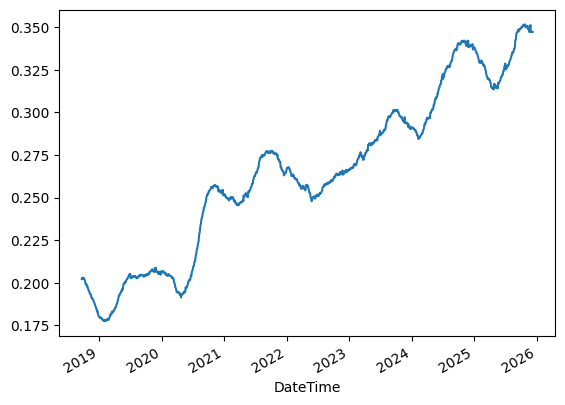

In [ ]:
# frac_volume.mean(axis=1).rolling(100).mean().plot()

/tmp/ipykernel_91060/1456649361.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (compare['pre'][i], compare['post'][i]))


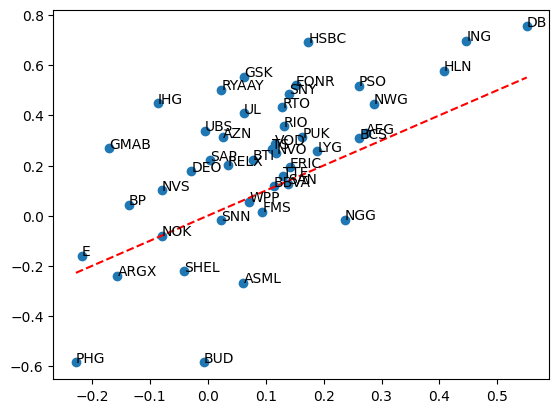

In [ ]:
import matplotlib.pyplot as plt

compare = pd.concat([pd.DataFrame(post_25_ic).iloc[3], pd.DataFrame(low_flow_ic).iloc[3]], axis=1)
compare.columns = ['pre','post']

plt.scatter(compare['pre'], compare['post'])
plt.plot([compare['pre'].min(), compare['pre'].max()], [compare['pre'].min(), compare['pre'].max()], 'r--')
# plt.xlim([-0.2, 0.3])
# plt.ylim([-0.2, 0.3])
# labeling each point
for i, txt in enumerate(compare.index):
    plt.annotate(txt, (compare['pre'][i], compare['post'][i]))

/tmp/ipykernel_817954/1754132511.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (compare['pre'][i], compare['post'][i]))


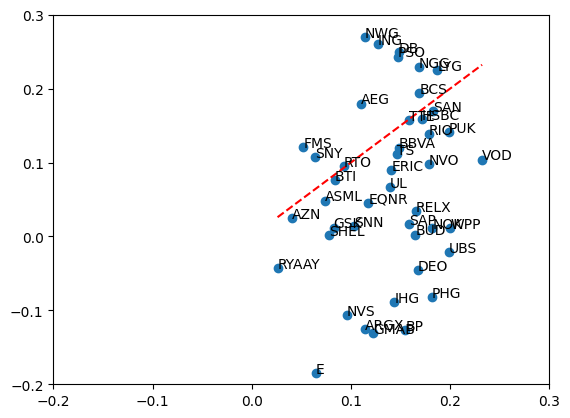

In [ ]:
import matplotlib.pyplot as plt

compare = pd.concat([pd.DataFrame(pre_25_ic).iloc[3], pd.DataFrame(post_25_ic).iloc[3]], axis=1)
compare.columns = ['pre','post']

plt.scatter(compare['pre'], compare['post'])
plt.plot([compare['pre'].min(), compare['pre'].max()], [compare['pre'].min(), compare['pre'].max()], 'r--')
plt.xlim([-0.2, 0.3])
plt.ylim([-0.2, 0.3])
# labeling each point
for i, txt in enumerate(compare.index):
    plt.annotate(txt, (compare['pre'][i], compare['post'][i]))

In [ ]:
print(pd.DataFrame(pre_25_ic).iloc[4])
print(pd.DataFrame(post_25_ic).iloc[4])

NOK      0.166019
LYG      0.165895
RELX     0.087980
RIO      0.195389
BBVA     0.195818
VOD      0.122314
TS       0.159305
SNY      0.061864
ASML     0.060150
DEO      0.090085
ERIC     0.107694
AEG      0.110507
HLN      0.094786
HSBC     0.176990
E        0.083299
BP       0.112900
RYAAY   -0.018446
NVS      0.074830
FMS      0.058181
PHG      0.166687
SNN      0.103272
SAP      0.145154
GMAB     0.108405
RTO      0.136498
EQNR     0.108698
IHG      0.082010
WPP      0.148296
SAN      0.195972
TTE      0.176514
AZN      0.017085
NGG      0.152551
GSK      0.064739
UL       0.138606
ARGX     0.093412
BCS      0.170959
SHEL     0.055443
PUK      0.172403
UBS      0.207030
NVO      0.144180
PSO      0.067256
BUD      0.164853
BTI      0.089159
NWG      0.104761
DB       0.141155
ING      0.119533
Name: 4, dtype: float64
NOK      0.063261
LYG      0.219301
RELX     0.016698
RIO      0.246984
BBVA     0.152699
VOD      0.112071
TS       0.154523
SNY      0.051606
ASML     0.083116
DEO 

In [ ]:
rio_df.loc[:'2024','signal'].corr(rio_df.loc[:'2024','hedged_ret'])

0.1686476858970593

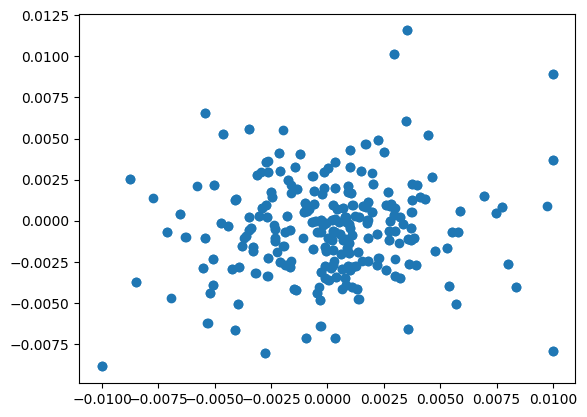

In [ ]:
rio_df = all_daily[close_df.columns.to_list().index('RIO')]

plt.scatter(rio_df.loc['2025':,'signal'], rio_df.loc['2025':,'hedged_ret'])

In [ ]:
rio_df = all_daily[close_df.columns.to_list().index('RIO')]

rio_df.loc[:'2024','signal'].corr(rio_df.loc[:'2024','hedged_ret'])

0.1686476858970593

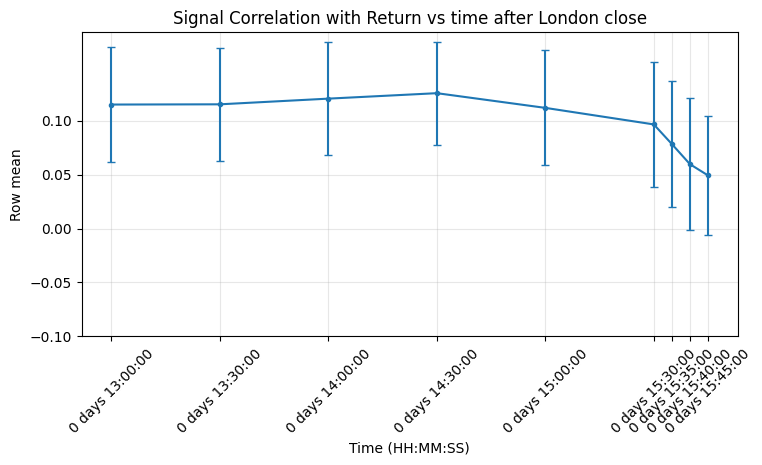

In [ ]:
import seaborn as sns

df = pd.DataFrame(all_hedged_ic)
df.index = pd.to_timedelta(measured_time)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

# --- Assume df is your DataFrame ---
# Rows = times (TimedeltaIndex), columns = series you want to average per row
# Example dtype check (optional):

# 1) Row-wise statistics
row_mean = df.mean(axis=1)                # average of each row
row_err  = df.std(axis=1, ddof=1)         # error bars = row-wise std
# If you prefer standard error of the mean (SEM), use:
# row_err = df.std(axis=1, ddof=1) / np.sqrt(df.shape[1])

# 2) Convert TimedeltaIndex to numeric (nanoseconds) for robust formatting
x_ns = df.index.values.astype('timedelta64[ns]').astype('int64')

# 3) Plot with error bars
fig, ax = plt.subplots(figsize=(8, 4))
ax.errorbar(
    x_ns, row_mean.values, yerr=row_err.values,
    fmt='-o', linewidth=1.5, capsize=3, markersize=3
)

# 4) Format x-axis to show HH:MM:SS (drop fractional seconds). Adjust to taste.
def td_formatter(v, pos):
    # v is in nanoseconds
    s = str(pd.to_timedelta(int(v), unit='ns'))
    return s.split('.')[0]  # strip fractional seconds like '00:01:23.456789'

ax.xaxis.set_major_formatter(FuncFormatter(td_formatter))
ax.xaxis.set_major_locator(MaxNLocator(nbins=8, prune=None))

ax.set_xlabel("Time (HH:MM:SS)")
ax.set_ylabel("Row mean")
ax.set_title("Signal Correlation with Return vs time after London close")

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.xticks(rotation=45)
plt.yticks([-0.1, -0.05, 0.0, 0.05, 0.10])
ax.set_xticks(x_ns)
ax.set_xticklabels([str(td).split('.')[0] for td in df.index])  # format HH:MM:SS
plt.show()


In [ ]:
all_sig = pd.read_parquet(os.path.join(signal_dir)).reset_index().pivot(index='index',
                                        columns='ticker',
                                        values='signal'
                                    )

In [ ]:
all_sig.loc['2025-05-01':].loc[:]

ticker,AEG,ARGX,ASML,AZN,BBVA,BCS,BP,BTI,BUD,DB,...,SAN,SAP,SHEL,SNN,SNY,TS,TTE,UL,VOD,WPP
index,,,,,,,,,,,,,,,,,,,,,
2025-01-02 11:29:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-02 11:30:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-02 11:31:00-05:00,-0.002653,-0.001146,-0.000842,-0.000187,-0.001357,-0.001384,0.000450,0.000680,0.000496,0.000100,...,0.000914,0.000152,0.000303,-0.001390,0.000389,0.001245,0.002562,-0.001150,0.000589,-0.004306
2025-01-02 11:32:00-05:00,-0.003014,-0.001290,-0.000833,-0.000120,-0.001864,-0.000512,0.000538,0.001277,0.000970,0.000284,...,0.000420,0.000024,0.000537,0.000080,0.000329,0.001150,0.002448,-0.000928,0.000659,-0.003741
2025-01-02 11:33:00-05:00,-0.000430,-0.001116,0.000843,0.000624,-0.000604,0.001017,0.001712,0.001928,0.001230,0.001269,...,0.001646,0.000809,0.001705,0.000503,0.000425,0.001847,0.002911,-0.000498,0.001588,-0.002702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-04 15:55:00-05:00,-0.001744,0.009965,0.012944,-0.008647,-0.001413,0.002238,0.005086,-0.003295,-0.001065,0.002479,...,-0.000576,-0.003094,0.001358,-0.004730,0.003271,-0.001379,0.001712,-0.001476,0.003197,0.003628
2025-11-04 15:56:00-05:00,-0.001773,0.010538,0.013472,-0.008975,-0.000948,0.002759,0.005683,-0.003092,-0.000757,0.003559,...,0.000373,-0.003188,0.002060,-0.005110,0.004465,-0.001653,0.001940,-0.001297,0.003221,0.004223
2025-11-04 15:57:00-05:00,-0.001499,0.010896,0.015684,-0.008980,-0.001149,0.002914,0.005498,-0.003240,0.000018,0.004347,...,0.000741,-0.002984,0.002141,-0.005573,0.005628,-0.000682,0.002007,-0.001420,0.003291,0.003759


In [ ]:
all_sig

,signal,ticker
2020-01-02 11:31:00-05:00,0.000417,AEG
2020-01-02 11:32:00-05:00,0.000405,AEG
2020-01-02 11:33:00-05:00,0.000369,AEG
2020-01-02 11:34:00-05:00,0.000000,AEG
2020-01-02 11:35:00-05:00,-0.000333,AEG
...,...,...
2025-11-04 15:55:00-05:00,0.003628,WPP
2025-11-04 15:56:00-05:00,0.004223,WPP
2025-11-04 15:57:00-05:00,0.003759,WPP
2025-11-04 15:58:00-05:00,0.003415,WPP


In [ ]:
import os
import pandas as pd